In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from altaipony.flarelc import FlareLightCurve

from astropy.io import fits    


import os


flux_label = r"Flux [e$^{-}$/s]"
time_label = "Time [BJD]"

# load all the file names
files = np.loadtxt("files.txt", dtype=str)

(4994, 10)
(4994, 10)


Found 1 candidate(s) in the (0,4994) gap.
/home/ilin/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


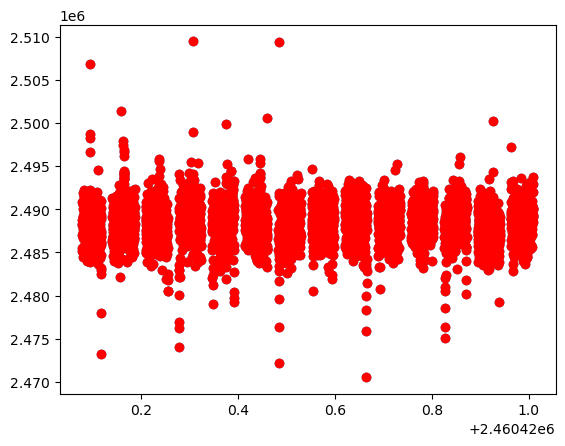

In [34]:
# GET THE DATA ---------------------------------------------------------------

# pick a file
file = files[13]

folder = "../data/hip67522/pipe_HIP67522/"

# load the detrended data
location = f"{folder}HIP67522_{file[1]}{file[0]}_detrended_lc.csv"
df = pd.read_csv(location)

print(df.shape)

plt.scatter(df.time, df.flux)
# use flag==0 to mask the big flare
df = df[df.flag == 0]

print(df.shape) 
plt.scatter(df.time, df.flux, c="r")


# FIND FLARES WITH ALTAIPONY ----------------------------------------------------

# define flare light curve
flc = FlareLightCurve(time = df.time, flux = df.flux, flux_err=np.std(df.flux))
flc.detrended_flux = df.flux
flc.detrended_flux_err = np.std(df.flux)

# find flares
flares = flc.find_flares(N1=3, N2=2, N3=3).flares


/home/ilin/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


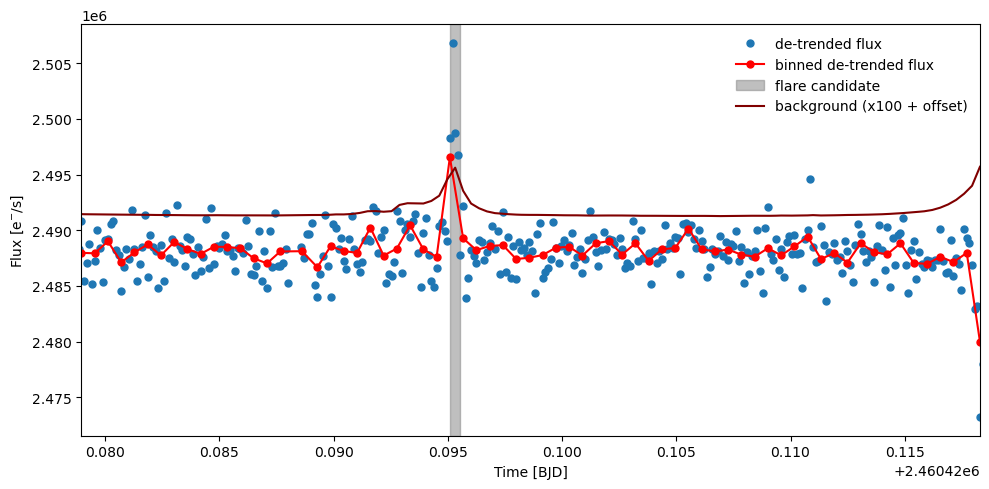

In [47]:
%matplotlib inline
# PLOT THE FLARE CANDIDATES ----------------------------------------------------------
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
      
    # how much to show around the flare
    window = 0.04

    # flare mask
    flare_m = (df.time > (row.tstart - window)) & (df.time < (row.tstop + window))

    # apply the mask
    tflare = df.time[flare_m].values
    fflare = df.flux[flare_m].values
    bgflare = df.bg[flare_m].values

    # calculate factor to scale the background
    rangetflare = np.max(fflare) - np.min(fflare)

    # scale the background
    bgflare = bgflare*100 + np.median(df.flux)#(bgflare - np.median(bgflare))*rangetflare/10 + np.median(df.flux) + rangetflare

    # plot the data
    plt.plot(tflare, fflare, ".", markersize=10, label="de-trended flux")

    # now bin the data to show in overlay
    binsize = 5

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    # bin the data
    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)

    # plot the binned data
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red", label="binned de-trended flux")

    # shade the region of the flare
    plt.axvspan(row.tstart, row.tstop, alpha=0.5, color="grey", label="flare candidate")
    
    plt.plot(tflare, bgflare, color="maroon", label="background (x100 + offset)")

    # layout
    plt.xlabel(time_label)
    plt.ylabel(flux_label)
    plt.legend(frameon=False)
    plt.xlim(binned_t[0], binned_t[-1])
    # plt.ylim(np.median(fflare) - 10*np.std(fflare), np.median(fflare) + 20*np.std(fflare))
    plt.tight_layout()
    plt.savefig(f"../plots/paper/false_positive_flare_{file[1]}{file[0]}_{i}.png")